In [1]:
%reset -f
from pythonrc import *

In [2]:
time_step = 1.0/1.0

actuators = [tunnel, voithschneider_port, voithschneider_starboard]
for actuator in actuators:
    actuator.extra_attributes["rate_limit"] = 1.0
    # actuator.extra_attributes.pop("reference_angle", None)


time_step = 0.1
gamma = [0.1, 0.1, 0.1]
mu = [0.1, 0.1, 0.1]
rho = [0.1, 0.1, 0.1]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.99, 0.4, 0.0]

table = dict_to_table({
    "Run": range(1, len(gamma) + 1),
    r"Frequency": [f"{1.0/time_step} Hz" for i in range(len(gamma))],
    r"$\gamma$" : gamma,
    r"$\mu$" : mu,
    r"$\rho$" : rho,
    r"$\zeta$" : zeta,
    r"$\lambda_i$" : lambda_p,
    r"$\bar{\Omega}_1$" : [actuators[0].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_2$" : [actuators[1].extra_attributes['rate_limit']] * len(gamma),
    r"$\bar{\Omega}_3$" : [actuators[2].extra_attributes['rate_limit']] * len(gamma),
})
display(Markdown(table))

| Run | Frequency | $\gamma$ | $\mu$ | $\rho$ | $\zeta$ | $\lambda_i$ | $\bar{\Omega}_1$ | $\bar{\Omega}_2$ | $\bar{\Omega}_3$ |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | 0.99 | 1.0 | 1.0 | 1.0 |
| 2 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | 0.4 | 1.0 | 1.0 | 1.0 |
| 3 | 10.0 Hz | 0.1 | 0.1 | 0.1 | 1.0 | 0.0 | 1.0 | 1.0 | 1.0 |


In [3]:
def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=[
            tunnel,
            voithschneider_port,
            voithschneider_starboard,
        ],
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )

def initialize_allocators():
    a = []
    for g, m, r, l, z in zip(gamma, mu, rho, lambda_p, zeta):
        a.append(
            initialize_allocator(
                skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
                gamma=g,
                mu=m,
                rho=r,
                zeta=z,
                time_step=time_step,
                lambda_=l,
            )
        )
    a.append(
        initialize_allocator(
            skadipy.allocator.reference_filters.MinimumMagnitude,
            gamma=0.1,
            mu=0.1,
            rho=0.1,
            time_step=time_step,
        )
    )
    return a

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$F_x$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$F_y$ [N]'>,
        <Axes: xlabel='Time [s]', ylabel='$M_z$ [N]'>], dtype=object))

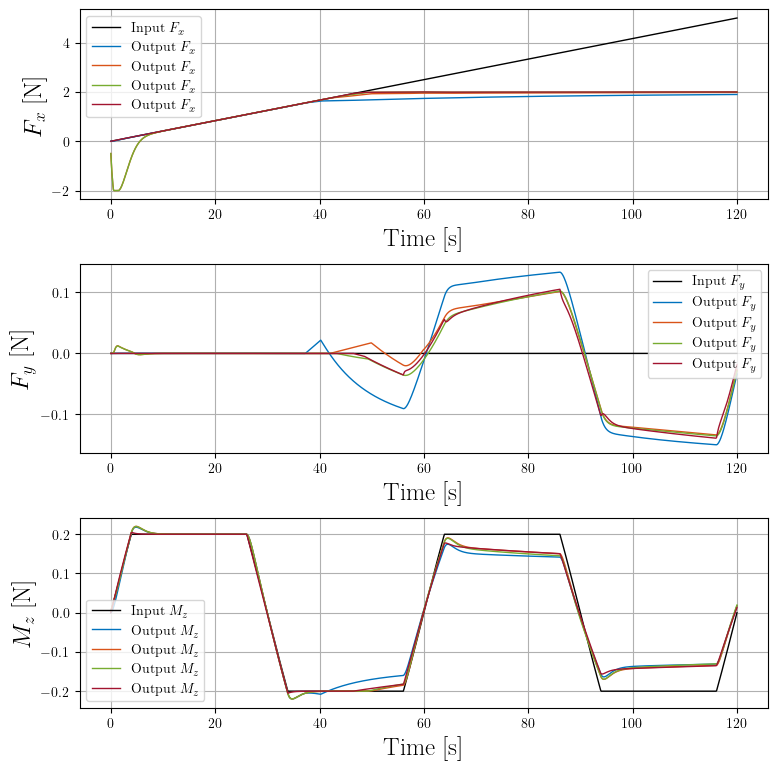

In [4]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0, 5, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd, allocators=initialize_allocators())
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist, dt=time_step)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='Tunnel [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Port [N]'>,
        <Axes: xlabel='Time [s]', ylabel='Starboard [N]'>], dtype=object))

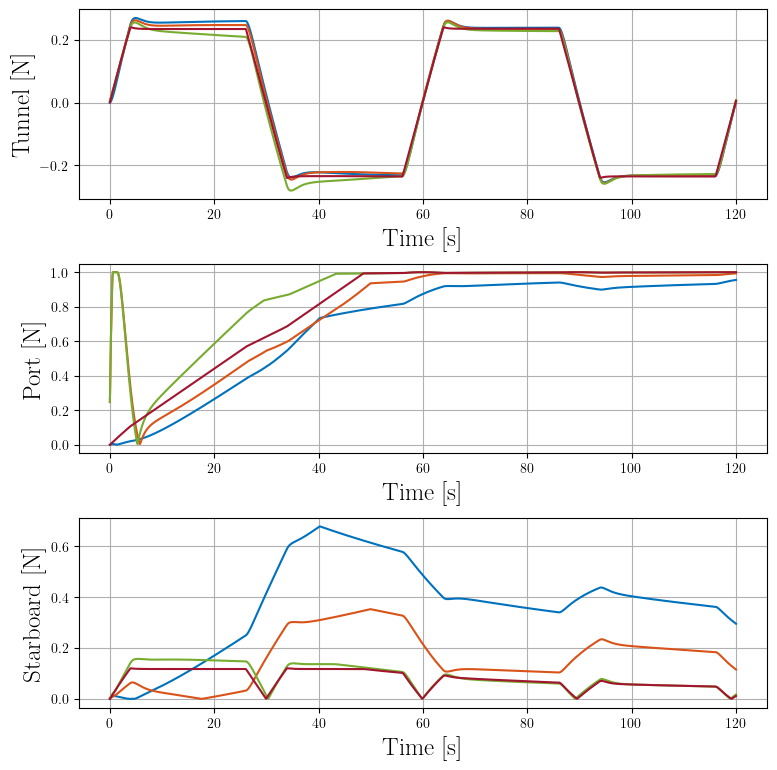

In [5]:
plot_thruster_forces(xi_hist, dt=time_step)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\emirc\AppData\Local\Temp\ipykernel_68568\189777241.py:4: SyntaxWarning: invalid escape sequence '\l'
  l.append(f"$\lambda_i = {i}$")


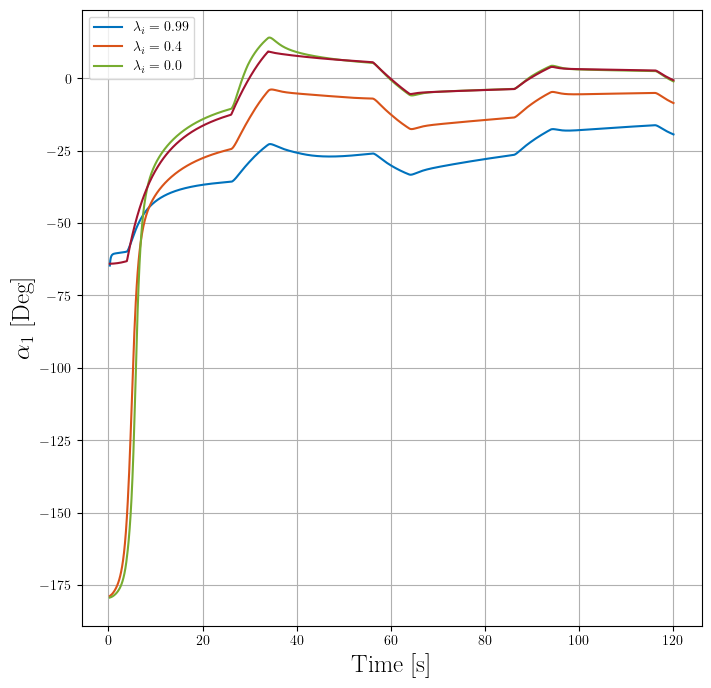

In [6]:
plot_angles(xi_hist, dt=time_step)
l = []
for i in lambda_p:
    l.append(f"$\lambda_i = {i}$")


plt.legend(l)
plt.grid(True)

(<Figure size 600x400 with 2 Axes>,
 array([<Axes: xlabel='Time [s]', ylabel='$\\theta_1$'>,
        <Axes: xlabel='Time [s]', ylabel='$\\theta_2$'>], dtype=object))

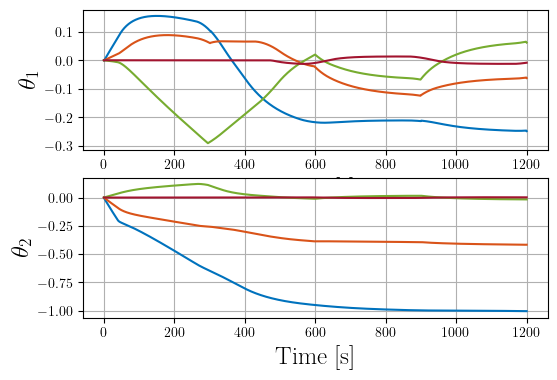

In [7]:
plot_theta_histories(theta_hist)

In [8]:
gamma.append(0.1)
mu.append(0.1)
rho.append(0.1)
lambda_p.append(0.0)

save_mat(
    filename="data/016.mat",
    dt=time_step,
    inputs=tau_cmd,
    xi_out=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)